# Hand Gesture CNN

## Dataset : [Hand Gesture Recognition Dataset](https://www.kaggle.com/gti-upm/leapgestrecog)
### 10 Gestures
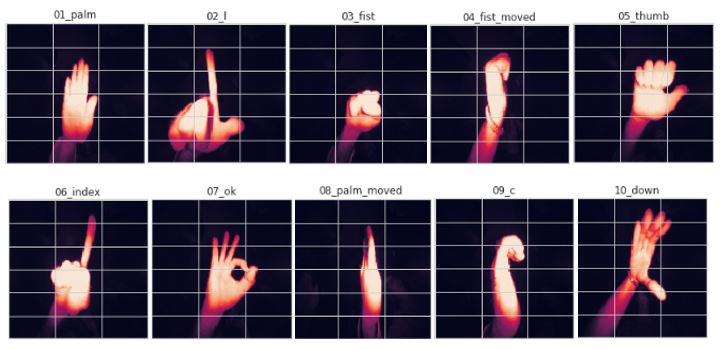

In [ ]:
import os
print(os.listdir("../input"))

In [ ]:
print(os.listdir("../input/leapgestrecog/leapGestRecog"))

In [ ]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import random as rn
import cv2    
from tqdm import tqdm                 
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)    

In [ ]:
# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
#dl libraraies

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten,Activation, Dense

from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

## Prepare Dataset

In [ ]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('../input/leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

In [ ]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('../input/leapgestrecog/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('../input/leapgestrecog/leapGestRecog/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = '../input/leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

In [ ]:
 # check some image
fig,ax=plt.subplots(2,5)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(y_data))  # len(y_data)=20000
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

In [ ]:
# One-Hot-Endcoing
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [ ]:
# Split Dataset
X_train,X_test,Y_train,Y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=42)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

In [ ]:
num_classes = 10 # Y_train.shape[1]

In [ ]:
del x_data
del y_data

## Build Model

In [ ]:
# Build Model
model = Sequential()
model.add(Conv2D(filters= 32, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters= 64, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters= 96, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters= 96, kernel_size = (3,3),padding = 'same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = "softmax"))
          
model.summary()

In [ ]:
# Compile Model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

## Train Model

In [ ]:
# Train Model
batch_size = 128
num_epochs = 10
History = model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, Y_test))

In [ ]:
# Save Model
model.save("hand-gesture.h5")

## Evaluate Model

In [ ]:
# Evaluate Model
score = model.evaluate(X_test, Y_test)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

## Show History

In [ ]:
# Show History
def show_history(t1, t2):
    plt.plot(History.history[t1])
    plt.plot(History.history[t2])
    plt.title("History of "+t1)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.legend([t1,t2])
    plt.show()

In [ ]:
show_history('acc', 'val_acc')
show_history('loss', 'val_loss')